In [1]:
import os
import sys
import gensim
import numpy as np

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

In [2]:
from matchms.importing.load_from_msp import load_from_msp
spectrums = list(load_from_msp('C:\\Users\\Gosia\\Desktop\\MoNA-export-GC-MS_Spectra-msp\\MoNA-export-GC-MS_Spectra.msp'))
print(len(spectrums))

18898


In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks

def apply_my_filters(s):
    if 'exactmass' in s.metadata:
        s.set('exactmass', float(s.metadata['exactmass']))
        s = select_by_mz(s, mz_from=0, mz_to=1000)
        s = normalize_intensities(s)
        s = require_minimum_number_of_peaks(s,5)
        s = select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1)
        return s

In [4]:
# apply filters to the data
spectrums_classical = [apply_my_filters(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums_classical if s is not None and 'inchikey' in s.metadata ]

print("{} remaining spectra.".format(len(spectrums)))

18731 remaining spectra.


In [5]:
# remove duplicate peaks
specs_by_peaks = {}
for s in spectrums:
    specs_by_peaks[''.join( ('%.0f' % p) for p in sorted(s.peaks[0]))] = s

In [6]:
spectrums = list(specs_by_peaks.values())

In [7]:
inchi_dict = {}
for s in spectrums:
    ik = s.metadata.get('inchikey','')
    init_ik = ik.split('-')[0]
    if not init_ik in inchi_dict:
        inchi_dict[init_ik] = [s]
    else:
        inchi_dict[init_ik].append(s)


In [8]:
query_size = 1000

In [9]:
# choosing queries from multis ensures a possible true match
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])
matching_keys = np.random.choice(list(multis), size=query_size, replace=False)

query_spec = {}
spectrums_lib = []
# We select query_size queries that have at least 1 matching spectrum in the library
for q in matching_keys:
    spec_to_add = np.random.choice(inchi_dict[q], size=1, replace=False)
    query_spec[spec_to_add[0].metadata['inchikey']] = spec_to_add[0]

# And everything else goes into the library
for s in spectrums:
    if s.metadata['inchikey'] not in query_spec or s != query_spec[s.metadata['inchikey']]:
        spectrums_lib.append(s)

spectrums_query = list(query_spec.values())

In [10]:
print(len(spectrums_query), len(spectrums_lib))

1000 13658


In [11]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]


In [12]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_gcms_model_75.model")

iterations = [1, 3, 5, 10, 15, 20, 25, 30]

# Train model with default parameters
model = train_new_word2vec_model(documents, iterations, model_file, size=75)

The value of size is set from 300 (default) to 75
  Epoch 1 of 30.Change in loss after epoch 1: 119041.65625
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_75_iter_1.model
  Epoch 2 of 30.Change in loss after epoch 2: 104470.765625
  Epoch 3 of 30.Change in loss after epoch 3: 103702.921875
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_75_iter_3.model
  Epoch 4 of 30.Change in loss after epoch 4: 87371.34375
  Epoch 5 of 30.Change in loss after epoch 5: 98585.59375
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_75_iter_5.model
  Epoch 6 of 30.Change in loss after epoch 6: 98009.34375
  Epoch 7 of 30.Change in loss after epoch 7: 95909.5
  Epoch 8 of 30.Change in loss after epoch 8: 94733.3125
  Epoch 9 of 30.Change in loss after epoch 9: 96520.9375
  Epoch 10 of 30.Change in loss after epoch 10: 96806.5625
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_

In [13]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_query = [SpectrumDocument(s, n_decimals=0) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=0) for s in spectrums_lib]

In [14]:
from tqdm.notebook import tqdm  # optional, just to get a progress bar
from spec2vec.vector_operations import calc_vector


intensity_weighting_power = 0.5
allowed_missing_percentage = 15 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_query = np.zeros((len(documents_query), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_query)):
    embeddings_spec2vec_query[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_lib)):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 75


In [15]:
from cosine_calc import get_spec2vec_hits

hits = get_spec2vec_hits(documents_query, documents_lib, metaKey='exactmass', model=model, precursor_tol=3,
                         intensity_weighting_power=intensity_weighting_power,
                         allowed_missing_percentage=allowed_missing_percentage,
                         embeddings_query=embeddings_spec2vec_query, embeddings_library=embeddings_spec2vec_lib)


In [16]:
# amount of false hits
print( len( [ h for h in hits if not h.hit ]))

349


In [17]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [18]:
from knockoffs import generate_knockoffs
diags = [6]

q_list_knockoffs = {}
for diag in diags:
        for comp in [5]:
                try:
                    knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=allowed_missing_percentage,n_components=comp, diagonal_matrix=diag)

                    hits_knockoffs = get_spec2vec_hits(documents_query, knockoff_documents, decoys=True, model=model, precursor_tol=3, metaKey="exactmass",
                                                       intensity_weighting_power=intensity_weighting_power,
                                                       allowed_missing_percentage=allowed_missing_percentage,embeddings_query=embeddings_spec2vec_query)
                    q_list_knockoffs[(diag, comp)] = calculate_q_value(hits+hits_knockoffs,True)
                except Exception as e:
                    print( diag, "failed", e )

Embedding vector size: 75


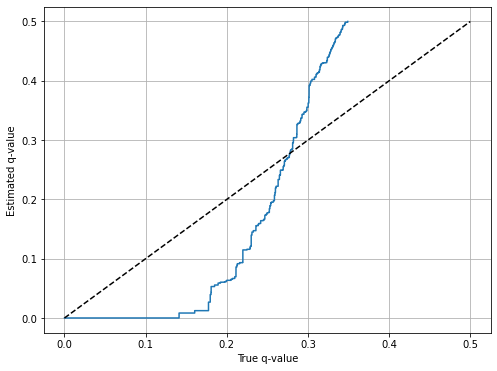

In [55]:
import plot_q_vals
plot_q_vals.plot_q_vals( q_list_true, q_list_knockoffs, labels=False )

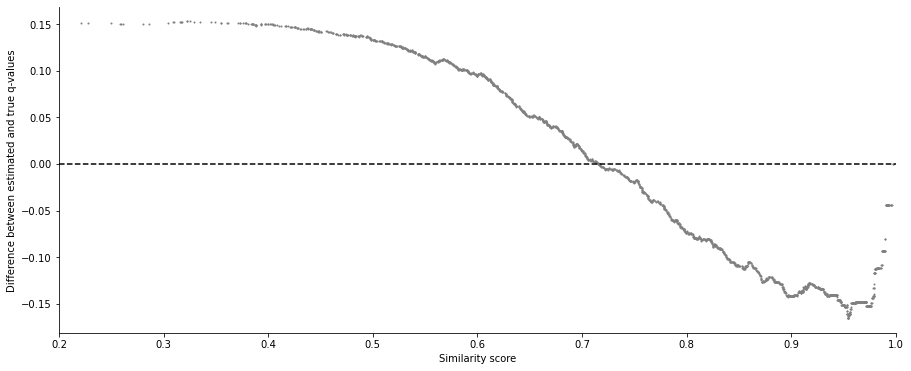

In [53]:
import pylab as plt
    
# plot estimated and true q-values
def combine_true_est_2(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_e-q_val_true[q_idx][0]))
    return res

def plot_q_vals3(trues, knockoffs):
    fig, ax = plt.subplots(figsize=(15,6))
    for label, knockoff in knockoffs.items():
            scores, ys = zip(*combine_true_est_2(q_list_true, knockoff))
            plt.plot(scores,ys, 'o', color='gray', markersize=1, label=label)
    plt.plot([0.2,1.0], [0,0], 'k--')
    plt.xlabel('Similarity score')
    plt.ylabel('Difference between estimated and true q-values')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim([0.2, 1.0])
         
    
plot_q_vals3(q_list_true,q_list_knockoffs)

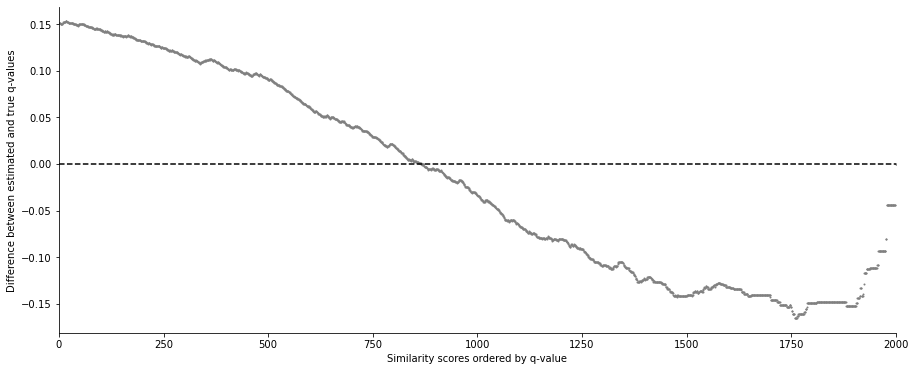

In [50]:
import pylab as plt

def plot_q_vals2(estimated, filename=None):
    fig, ax = plt.subplots(figsize=(15,6))

    for label, (tru,est) in estimated.items():
        plt.plot(range(len(tru),0,-1), [e-t for t,e in zip(tru,est)], 'o', color='gray', markersize=1, label=label)
    plt.plot([0,2000], [0,0], 'k--')
    plt.xlabel('Similarity scores ordered by q-value')
    plt.ylabel('Difference between estimated and true q-values')
    if filename is not None:
        plt.savefig(filename)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim([0, 2000])



plot_q_vals2( to_plot )
